In [146]:
import tensorflow as tf
import numpy as np
import math
from typing import Sequence
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from librosa._typing import _STFTPad
import time, random

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# ------------------------------
# Config (edit to your needs)
# ------------------------------
SR = 22050
NFFT = 1024
HOP = 512
NMELS = 128
FMIN = 200.0
FMAX = 8000.0

FRAME_LENGTH = NFFT
FRAME_STEP = HOP

LOG_EPS = 1e-6

PAR = tf.data.AUTOTUNE
PREF = 2

# Different functions for each dataset
def load_birdclef(audio_root, path, target, folds=5):
    df = pd.read_csv(path)
    
    df["path"] = audio_root + "/" + df["primary_label"] + "/" + df["filename"]
    
    # Sanity check
    dups = df['path'].duplicated().sum()  # or 'filename'
    print("Duplicate file rows:", dups)
    
    # Drop all species with less than 10 recordings
    counts = df["primary_label"].value_counts()
    keep = counts[counts >= 50].index
    df = df[df["primary_label"].isin(keep).reset_index(drop=True)]
    
    # Generate the binary labels
    y = (df['primary_label'] == target).astype(int).values
    
    
    # Get k folds
    skf = StratifiedKFold(folds, shuffle=True, random_state=42)
    splits = []
    for tr, va in skf.split(df, y):
        splits.append({
            "train":tr, 
            "val": va, 
            "train_size": len(tr),
            "val_size": len(va),
            "train_pos_ratio": y[tr].mean(),
            "val_pos_ratio": y[va].mean(),
            }
        )
    
    return df, splits

################################
# Data Augmentations #
################################
def calc_rms_dbfs(x):
    rms = np.sqrt(np.mean(np.square(x)) + 1e-12)
    rms = 20.0 * np.log(rms + 1e-12) / np.log(10.0)
    return rms 

def aug_rms_normalize(x, target_db=-20.0):
    cur = calc_rms_dbfs(x)
    gain_db = target_db - cur
    gain = np.power(10.0, gain_db / 20.0)
    y = x * gain
    return np.clip(y, -1.0, 1.0)

def aug_volume_jitter(x, min_db=-6.0, max_db=6.0):
    gain_db = tf.random.uniform([], min_db, max_db)
    gain = tf.pow(10.0, gain_db / 20.0)
    y = x * gain
    return tf.clip_by_value(y, -1.0, 1.0)

def aug_gaussian_noise_snr(x, snr_db=5.0):
    # Scale Gaussian noise to achieve target SNR in dB
    rms_sig = tf.sqrt(tf.reduce_mean(tf.square(x)) + 1e-12)
    snr_lin = tf.pow(10.0, snr_db / 20.0)
    rms_noise = rms_sig / snr_lin
    noise = tf.random.normal(tf.shape(x))
    noise_rms = tf.sqrt(tf.reduce_mean(tf.square(noise)) + 1e-12)
    noise = noise * (rms_noise / (noise_rms + 1e-12))
    y = x + noise
    return tf.clip_by_value(y, -1.0, 1.0)

def aug_gaussian_noise(audio, snr_db = 10.0):
    """
    Add Gaussian noise to a waveform at a given SNR (dB).
    
    audio: np.ndarray, waveform
    snr_db: target signal-to-noise ratio in dB
    """
    # Calculate RMS of the original signal
    rms_signal = np.sqrt(np.mean(audio**2))
    
    # Desired RMS of noise
    snr_linear = 10**(snr_db / 20)
    rms_noise = rms_signal / snr_linear
    
    # Generate Gaussian noise
    noise = np.random.normal(0, 1, len(audio))
    rms_noise_current = np.sqrt(np.mean(noise**2))
    noise = noise * (rms_noise / rms_noise_current)
    
    print(noise)
    
    return audio + noise

def aug_loudness_normalize(y: np.ndarray, target_db: float = -20.0) -> np.ndarray:
    """
    Normalize waveform to a target RMS level in dBFS.
    
    y : waveform (numpy array, float32 or float64, range -1..1)
    target_db : desired RMS level in dBFS (e.g. -20 dB)
    
    Returns normalized waveform (clipped to [-1, 1]).
    """
    rms = np.sqrt(np.mean(y**2) + 1e-12)
    current_db = 20 * np.log10(rms + 1e-12)
    gain_db = target_db - current_db
    gain = 10**(gain_db / 20)
    y_norm = y * gain
    return np.clip(y_norm, -1.0, 1.0)

def aug_spec_augment(mel, num_time_masks=2, time_mask_width=16, num_freq_masks=2, freq_mask_width=8):
    n_mels = tf.shape(mel)[0]
    T = tf.shape(mel)[1]
    m = tf.identity(mel)

    def mask_freq(m):
        w = tf.random.uniform([], 0, freq_mask_width + 1, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, tf.maximum(1, n_mels - w + 1), dtype=tf.int32)
        mask = tf.concat([
            tf.ones([f0, T], m.dtype),
            tf.zeros([w, T], m.dtype),
            tf.ones([n_mels - f0 - w, T], m.dtype)
        ], axis=0)
        return m * mask

    def mask_time(m):
        w = tf.random.uniform([], 0, time_mask_width + 1, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, tf.maximum(1, T - w + 1), dtype=tf.int32)
        left = tf.ones([n_mels, t0], m.dtype)
        mid  = tf.zeros([n_mels, w], m.dtype)
        right= tf.ones([n_mels, T - t0 - w], m.dtype)
        mask = tf.concat([left, mid, right], axis=1)
        return m * mask

    for _ in range(num_freq_masks):
        m = mask_freq(m)
    for _ in range(num_time_masks):
        m = mask_time(m)
    return m

# ------------------------------
# Helpers: audio decode + loudness + augment
# ------------------------------

def build_file_lists(df, split, target):
    # This function creates lists of filepaths for the split
    # This results in 4 lists, train_pos, train_neg, val_pos and val_neg
    tr_idx, va_idx = split["train"], split["val"]
    train = df.iloc[tr_idx]; val = df.iloc[va_idx]
    
    pos_train = train[train.primary_label == target]["path"].tolist()
    neg_train = train[train.primary_label != target]["path"].tolist()

    pos_val = val[val.primary_label == target]["path"].tolist()
    neg_val = val[val.primary_label != target]["path"].tolist()
    return (pos_train, neg_train), (pos_val, neg_val)

def plan_epoch(n_pos_train, pos_exposures=1.0, neg_ratio=1.0, batch_size=32, pos_ratio=0.5):
    # This function plans the amount of positive and negative samples per training
    # epoch. This ensures that we don't train on all the negatives and we can 
    # tune the amount of positives that we see
    
    # n_pos_train: unique positive files in the train split
    # pos_exposures: how many times you want to see each positive per epoch on average (1.0 ≈ once)
    # neg_ratio: negatives per positive overall (1.0 = 1:1, 2.0 = twice as many negs)
    # pos_ratio: within-batch sampling weight for positives (0.5 = 50/50)
    
    P_pos = math.ceil(n_pos_train * pos_exposures)
    # keep the global neg:pos = neg_ratio (independent of within-batch pos_ratio)
    P_neg = math.ceil(P_pos * neg_ratio)

    total_examples = P_pos + P_neg
    steps_per_epoch = math.ceil(total_examples / batch_size)
    return P_pos, P_neg, steps_per_epoch

# ------------------------------
# Feature extraction: power log-mel
# ------------------------------

def generate_mel_spectrogram(audio, seconds=3, sr = 22050, n_fft=1024, n_mels=128, hop_length=512, win_length=512, 
                       window:str='hann', center=True, pad_mode:_STFTPad='constant', power=2.0, fmin=20, 
                       fmax=16000, norm='slaney'): 
        
    if (len(audio) / sr) > seconds:
        audio = audio[:(sr * seconds)]   
        
    # Generate mel spectrogram
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode, power=power, fmin=fmin, fmax=fmax, norm=norm)
    # Convert to dB
    spec = librosa.power_to_db(spec, ref=np.max)

    return spec

def load_audio_file(path, sample_rate=22050):
    y, sr = librosa.load(path, sr=sample_rate)
    return y
    

# ------------------------------
# Dataset builders
# ------------------------------
def make_waveform_ds(file_paths: Sequence[str], label: int, shuffle=True, sample_rate=22050):
    # Convert the raw audio into a tensorflow dataset based on the paths
    ds = tf.data.Dataset.from_tensor_slices((list(file_paths), tf.fill([len(file_paths)], label)))
    if shuffle:
        ds = ds.shuffle(buffer_size=512, reshuffle_each_iteration=True)
    
    ds = ds.map(lambda path, label: (load_audio_file(path), tf.cast(label, dtype=tf.float32)), num_parallel_calls=tf.data.AUTOTUNE)

    return ds
# ------------------------------
# Simple model + focal loss (optional)
# ------------------------------
def make_cnn(input_time=None):
    inp = tf.keras.Input(shape=(NMELS, input_time), name="mel")  # time can be variable (None)
    x = tf.keras.layers.Permute((2,1))(inp)  # [B, T, n_mels]
    x = tf.keras.layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inp, out)

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1.), y_pred, 1. - y_pred)
        w = tf.where(tf.equal(y_true, 1.), alpha, 1. - alpha)
        return tf.reduce_mean(-w * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss

os.chdir("/home/joris/Thesis/new_attempt")

target = "rucwar"

birdclef_df, splits = load_birdclef("datasets/birdclef_2021/train_short_audio", "datasets/birdclef_2021/train_metadata.csv", target=target, folds=5)
split = splits[0]  # pick a fold

# File lists for that fold
train = birdclef_df.iloc[split["train"]]
val   = birdclef_df.iloc[split["val"]]
(pos_tr, neg_tr), (pos_va, neg_va) = build_file_lists(birdclef_df, split, target)

print("Dataset Information")
print(f"Training: Pos: {len(pos_tr)}, Neg: {len(neg_tr)}")
print(f"Validation: Pos: {len(pos_va)}, Neg: {len(neg_va)}")

TRAIN_NEG_RATIO = 2
VAL_NEG_RATIO = 2

# plan the budgets for the training
P_pos, P_neg, steps = plan_epoch(n_pos_train=len(pos_tr),
                                 pos_exposures=1.0,   # ~see each positive once/epoch
                                 neg_ratio=TRAIN_NEG_RATIO,       # 1:1 overall
                                 batch_size=32)

print(f"Positive Samples: {P_pos}, Negative Samples: {P_neg}, steps: {steps}")

def build_xy(file_list, label):
    X_list = []
    for path in file_list:
        wav = load_audio_file(path)
        # Perform augmentation on training data
        if (label == 0):
            wav = aug_gaussian_noise(audio=wav, snr_db=1)
            wav = aug_rms_normalize(wav)
        
        spec = generate_mel_spectrogram(wav)
        X_list.append(spec.astype(np.float32))
    X = np.stack(X_list, axis=0)                    # [N, mels, frames]
    y = np.full((len(file_list),), label, dtype=np.int32)
    return X, y

t0 = time.time()

neg_tr_sample = random.sample(neg_tr, P_neg)
neg_va_sample = random.sample(neg_va, len(pos_va) * VAL_NEG_RATIO)


TF: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Duplicate file rows: 0
Dataset Information
Training: Pos: 123, Neg: 49452
Validation: Pos: 31, Neg: 12363
Positive Samples: 123, Negative Samples: 246, steps: 12


Raw:  (224000,)
Resampled:  (112000,)
Noise:  (17085,)
To short
Fade:  (34170,)
Band Filter:  (34170,)
DB Mel Spectrogram:  (134, 128)


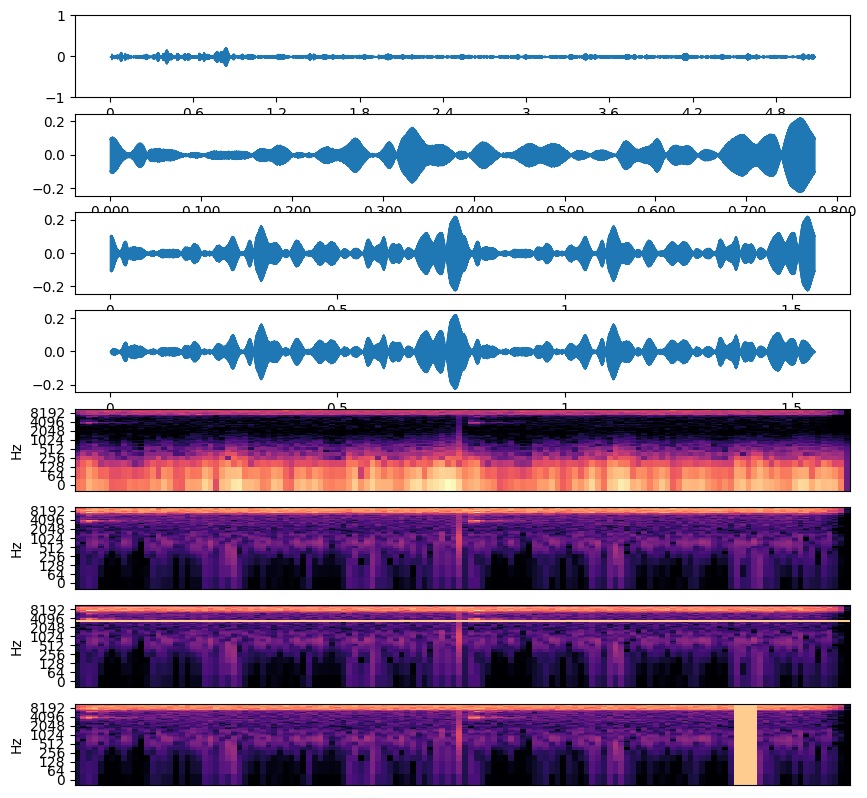

In [147]:
# Data examination
import tensorflow_io as tfio
SAMPLE_RATE = 16000
SPECTROGRAM_SECONDS = 3
FILL_TYPE = "tile" # pad | tile

# Load audio file as tensor
audio_file = tfio.audio.AudioIOTensor(pos_tr[4])

# Remove last dimension
waveform = tf.squeeze(audio_file[:audio_file.rate * 7], axis=[-1])
print("Raw: ", waveform.get_shape())

waveform = tfio.audio.resample(waveform, rate_in=32000, rate_out=SAMPLE_RATE)
print("Resampled: ", waveform.get_shape())

fig, axs = plt.subplots(8, figsize=(10, 10))

axs[0].set_ylim(-1, 1)

librosa.display.waveshow(waveform.numpy(), ax=axs[0])

# Trim the noise from the audio
position = tfio.audio.trim(waveform, axis=0, epsilon=0.1)

start = position[0]
stop = position[1]

processed = waveform[start:stop]
print("Noise: ", processed.get_shape())

librosa.display.waveshow(processed.numpy(), ax=axs[1])

processed = waveform[start:stop]
frame_count = tf.shape(processed)
# Calculate end padding
if (frame_count < SR):
    print("To short")
    if FILL_TYPE == "pad":
        padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
        processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    elif FILL_TYPE == "tile":
        repeats = tf.maximum(1, int((SAMPLE_RATE * SPECTROGRAM_SECONDS) / frame_count))
        processed = tf.tile(processed, [repeats])
else:
    padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
    processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    
librosa.display.waveshow(processed.numpy(), ax=axs[2])

# Fade in and out
fade = tfio.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")
librosa.display.waveshow(fade.numpy(), ax=axs[3])
print("Fade: ", fade.get_shape())

# Band filter
from scipy import signal
b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
band_filter = tf.cast(tf.convert_to_tensor(signal.lfilter(b, a, fade)), tf.float32)
print("Band Filter: ", band_filter.get_shape())

# Spectrograms
spectrogram = tfio.audio.spectrogram(fade, nfft=1024, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
print("DB Mel Spectrogram: ", db_mel_spectrogram.get_shape())

librosa.display.specshow(tf.transpose(db_mel_spectrogram).numpy(), ax=axs[4], y_axis="log", cmap="magma")

spectrogram = tfio.audio.spectrogram(band_filter, nfft=1024, window=512, stride=256)
mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

librosa.display.specshow(tf.transpose(db_mel_spectrogram).numpy(), ax=axs[5], y_axis="log")

# SpecAugment
# Freq masking
freq_mask = tfio.audio.freq_mask(db_mel_spectrogram, param=10)

librosa.display.specshow(tf.transpose(freq_mask).numpy(), ax=axs[6], y_axis="log")

# Time masking
time_mask = tfio.audio.time_mask(db_mel_spectrogram, param=10)

librosa.display.specshow(tf.transpose(time_mask).numpy(), ax=axs[7], y_axis="log")

plt.show()


In [148]:
def audio_pipeline(filename, augment=False, gaussian=0):
    # Load audio file as tensor
    audio_file = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)
    
    # Remove last dimension
    waveform = tf.squeeze(audio_file[:audio_file.rate * SPECTROGRAM_SECONDS], axis=[-1], name="Squeeze")

    waveform = tfio.audio.resample(waveform, rate_in=tf.cast(audio_file.rate, tf.int64), rate_out=SAMPLE_RATE, name="Resample")
    
    if False:
        # Trim the noise from the audio
        position = tfio.audio.trim(waveform, axis=0, epsilon=0.1, name="Trim")
        
        start = position[0]
        stop = position[1]

        processed = waveform[start:stop]
    else:
        processed = waveform[:SAMPLE_RATE * SPECTROGRAM_SECONDS]
        
    # if gaussian > 0:
    #     processed = aug_gaussian_noise_snr(processed, gaussian)
    
    frame_count = tf.shape(processed)
    # Calculate end padding
    if (frame_count < SR):
        processed = waveform
        frame_count = tf.shape(processed)
    
    if FILL_TYPE == "pad":
        padding = tf.maximum(0, (SAMPLE_RATE * SPECTROGRAM_SECONDS) - frame_count[0])
        processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    elif FILL_TYPE == "tile":
        repeats = tf.maximum(tf.cast(1, tf.int64), 1 + tf.cast(((SAMPLE_RATE * SPECTROGRAM_SECONDS) / frame_count), tf.int64))
        
        processed = tf.repeat(processed, repeats)
        # Reduce size to max 
        processed = processed[:SAMPLE_RATE * SPECTROGRAM_SECONDS]
        
    if augment:
        # Fade in and out
        fade = tfio.audio.fade(
            processed, fade_in=1000, fade_out=2000, mode="logarithmic", name="Fade")
    else:
        fade = processed
        
    # Band filter
    from scipy import signal
    b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
    band_filter = tf.py_function(signal.lfilter, [b, a, fade], Tout=tf.float32, name="Filter")

    spectrogram = tfio.audio.spectrogram(band_filter, nfft=1024, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=20, fmax=8000)
    db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, -1)
    
    db_mel_spectrogram = tf.transpose(db_mel_spectrogram, perm=[1, 0 ,2])
    
    db_mel_spectrogram = tf.ensure_shape(db_mel_spectrogram, (128, 188, 1))
    
    return db_mel_spectrogram

# audio_pipeline(pos_tr[2])

In [149]:
def create_dataset(pos, neg, augment=True, shuffle=0):
    # Takes all positive training samples
    # Adds new ones based on augmentations such as gaussian noise
    # Takes neg_ratio * num_of_training samples as negative samples
    # Computes decibel scaled log mel spectrograms and adds labels
    # Results in a tensorflow dataset
    
    ds_pos = tf.data.Dataset.from_tensor_slices((pos, tf.ones([len(pos)], dtype=tf.float32)))
    ds_pos = ds_pos.map(lambda x, y: (audio_pipeline(x, augment=augment), y), num_parallel_calls=tf.data.AUTOTUNE)
    print(f"Positive Samples: {ds_pos.cardinality()}")
        
    ds_neg = tf.data.Dataset.from_tensor_slices((neg, tf.zeros([len(neg)], dtype=tf.float32)))
    ds_neg = ds_neg.map(lambda x, y: (audio_pipeline(x, augment=False), y), num_parallel_calls=tf.data.AUTOTUNE)
    print(f"Negative Samples: {ds_neg.cardinality()}")

    ds = ds_pos.concatenate(ds_neg)
    # ds = ds.concatenate(ds_pos_aug)
    if shuffle > 0:
        ds = ds.shuffle(buffer_size=shuffle, reshuffle_each_iteration=True)
    print(f"Final set: {ds.cardinality()}")
    return ds
    
train_ds = create_dataset(pos_tr, neg_tr_sample, augment=True, shuffle=len(pos_tr) + len(neg_tr_sample))
train_ds = train_ds.batch(32).cache()
val_ds = create_dataset(pos_va, neg_va_sample, augment=False)
val_ds = val_ds.batch(32).cache()

Positive Samples: 123


Negative Samples: 246
Final set: 369


Positive Samples: 31


Negative Samples: 62
Final set: 93


In [150]:
%load_ext tensorboard
# %tensorboard --logdir=logs/fit

import tensorflow as tf
from tensorflow.keras import layers, models

def early_stopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_prc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

def build_minicnn_aed(
    input_shape=(128, 192, 1),   # (mels, frames, 1)
    num_classes=1,
    base_channels=32,
    dropout=0.15,
    use_layernorm=True,          # safer than BatchNorm for small batches
    output_bias=0.5
):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    def norm():
        return layers.LayerNormalization(axis=[1,2,3]) if use_layernorm else layers.BatchNormalization()

    inp = layers.Input(shape=input_shape)

    x = inp
    # Block 1
    x = layers.Conv2D(base_channels, 3, padding="same", use_bias=not use_layernorm)(x)
    x = norm()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)   # (mels/2, frames/2)
    x = layers.Dropout(dropout)(x)

    # Block 2
    x = layers.Conv2D(base_channels*2, 3, padding="same", use_bias=not use_layernorm)(x)
    x = norm()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)   # (mels/4, frames/4)
    x = layers.Dropout(dropout)(x)

    # Block 3
    x = layers.Conv2D(base_channels*4, 3, padding="same", use_bias=not use_layernorm)(x)
    x = norm()(x)
    x = layers.ReLU()(x)
    # Pool more on frequency than time to keep temporal detail a bit
    x = layers.MaxPooling2D(pool_size=(2,1))(x)   # (mels/8, frames/4)
    x = layers.Dropout(dropout)(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 1:
        out = layers.Dense(1, activation="sigmoid", bias_initializer=output_bias)(x)
        loss = tf.keras.losses.BinaryCrossentropy()
        metrics = [
            tf.keras.metrics.MeanSquaredError(name='Brier score'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
    else:
        out = layers.Dense(num_classes, activation="softmax", bias_initializer=output_bias)(x)
        loss = tf.keras.losses.CategoricalCrossentropy()
        metrics = ["accuracy"]

    model = models.Model(inp, out, name="minicnn_aed")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=loss, metrics=metrics)
    return model

import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='1,32')


ERROR:root:Failed to start profiler: Another profiler is running.


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [151]:

BATCH_SIZE = 32

# model = build_minicnn_aed(input_shape=(128, 188, 1))

# results = model.evaluate(train_ds, batch_size=BATCH_SIZE, verbose=0)
# print("Without Initial Bias Loss: {:0.4f}".format(results[0]))

def compute_output_bias(P_pos, P_neg):
    """
    Compute log-odds bias initializer for a sigmoid output layer.
    """
    if P_pos == 0 or P_neg == 0:
        return 0.0  # fallback: neutral bias
    prior = P_pos / (P_pos + P_neg)
    bias = np.log(prior / (1.0 - prior))
    return bias

initial_bias = compute_output_bias(P_pos, P_neg)

model = build_minicnn_aed(input_shape=(128, 188, 1), output_bias=initial_bias)

import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

model = build_minicnn_aed(input_shape=(128, 188, 1))
model.load_weights(initial_weights)

# Train the model
baseline_history = model.fit(
    train_ds,
    epochs=50,
    callbacks=[early_stopping(),tensorboard_callback],
    validation_data = val_ds
)

Epoch 1/50


ERROR:root:Failed to start profiler: Another profiler is running.


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 598ms/step - Brier score: 0.2533 - accuracy: 0.5908 - auc: 0.5392 - fn: 79.0000 - fp: 72.0000 - loss: 0.7309 - prc: 0.3626 - precision: 0.3793 - recall: 0.3577 - tn: 174.0000 - tp: 44.0000 - val_Brier score: 0.2495 - val_accuracy: 0.6667 - val_auc: 0.7695 - val_fn: 31.0000 - val_fp: 0.0000e+00 - val_loss: 0.7170 - val_prc: 0.5854 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 62.0000 - val_tp: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - Brier score: 0.2379 - accuracy: 0.6504 - auc: 0.5112 - fn: 120.0000 - fp: 9.0000 - loss: 0.6759 - prc: 0.3470 - precision: 0.2500 - recall: 0.0244 - tn: 237.0000 - tp: 3.0000 - val_Brier score: 0.2282 - val_accuracy: 0.6667 - val_auc: 0.6761 - val_fn: 31.0000 - val_fp: 0.0000e+00 - val_loss: 0.6491 - val_prc: 0.5047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 62.0000 - val_tp: 0.0000e+00
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - Brier score: 0.2235 - accurac

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Brier score: 0.1723 - accuracy: 0.8065 - auc: 0.8085 - fn: 18.0000 - fp: 0.0000e+00 - loss: 1.0261 - prc: 0.7951 - precision: 1.0000 - recall: 0.4194 - tn: 62.0000 - tp: 13.0000
[[3.67161731e-04]
 [1.09026162e-02]
 [1.76673889e-01]
 [3.67161731e-04]
 [3.06523800e-01]
 [3.67161731e-04]
 [3.58167477e-02]
 [3.67161731e-04]
 [9.98317599e-01]
 [3.67161731e-04]
 [8.43244731e-01]
 [2.49749478e-02]
 [3.70507836e-02]
 [4.57272440e-01]
 [3.20413634e-02]
 [3.67161731e-04]
 [3.67161731e-04]
 [7.61249103e-05]
 [3.97515530e-03]
 [9.97336447e-01]
 [9.89768744e-01]
 [9.97336447e-01]
 [9.89768744e-01]
 [1.00511834e-01]
 [9.89768744e-01]
 [9.97336447e-01]
 [9.89768744e-01]
 [9.89768744e-01]
 [9.89768744e-01]
 [9.89768744e-01]
 [9.89768744e-01]
 [5.32999460e-04]
 [3.86941902e-05]
 [1.13595342e-02]
 [7.40691200e-02]
 [1.12796413e-04]
 [7.40691200e-02]
 [7.40691200e-02]
 [1.74844157e-04]
 [

2025-08-27 23:50:25.550518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


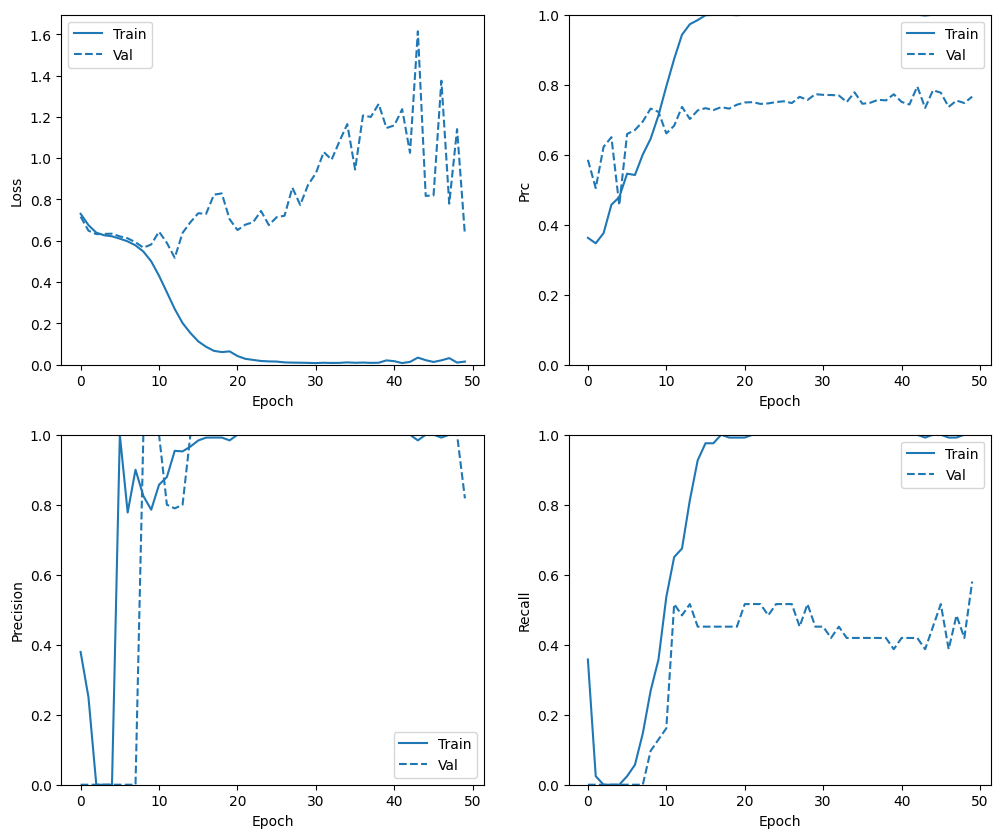

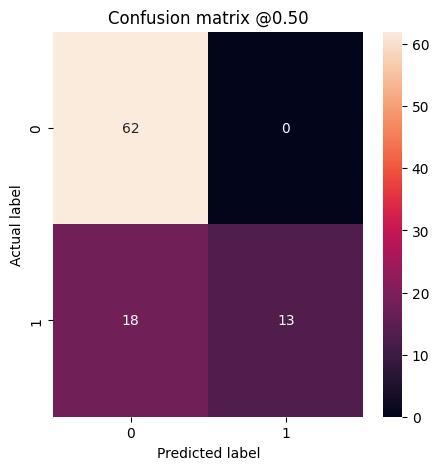

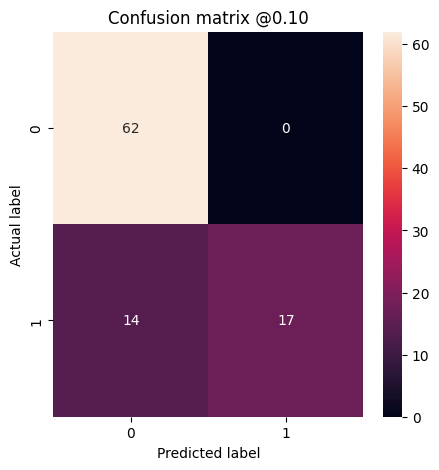

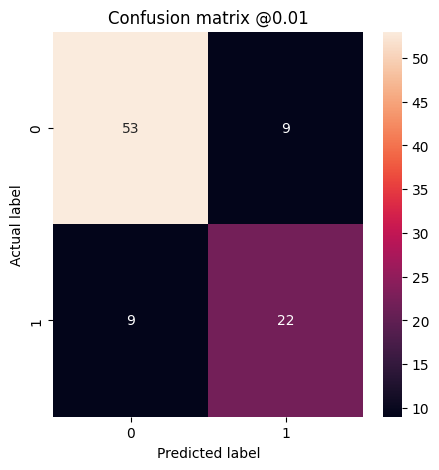

In [153]:
plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(baseline_history)

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

train_predictions_baseline = model.predict(train_ds, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(val_ds, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(val_ds, batch_size=BATCH_SIZE, verbose=1)

test_labels = np.concatenate([y for x, y in val_ds], axis=0)

plot_cm(test_labels, test_predictions_baseline)
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

print(test_predictions_baseline)